In [28]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import h5py
import glob
import powerlaw
import matplotlib.cm as cm
import matplotlib.colors as colors
import illustris_python as il
import matplotlib.gridspec as gridspec

In [29]:
def get_data_from_fof_file(basepath, i, param1, param2):
    path = glob.glob(basepath+f"fof_subhalo_tab_*{i}.hdf5")[0]
    with h5py.File(path, "r") as f:
        # f.visititems(print_structure)
        cds = f[f'{param1}/{param2}'][:]
    
    return cds

def get_data_from_file(basepath, i, param):
    path = glob.glob(basepath+f"snap_*{i}.hdf5")[0]
    with h5py.File(path, "r") as f:
        cds = f[f'PartType1/{param}'][:]
    
    return cds

def get_cosmo_parameters(basepath):
    path = basepath+"param.txt-usedvalues"
    Omega0 = None
    OmegaLambda = None
    HubbleParam = None
    
    with open(path, "r") as f:
        for line in f:
            if "Omega0" in line:
                Omega0 = float(line.split()[-1])
            if "OmegaLambda" in line:
                OmegaLambda = float(line.split()[-1])
            if "HubbleParam" in line:
                HubbleParam = float(line.split()[-1])
    
    return Omega0, OmegaLambda, HubbleParam
    
def get_halo_mass_function(subhalo_masses, box_size, n_bins=50, log_binning=True):

    ############# Create log bins #############
    subhalo_masses = subhalo_masses * 1e10  # convert to solar masses

    min_subhalo_mass = np.log10(subhalo_masses.min())
    max_subhalo_mass = round(np.log10(subhalo_masses.max()))

    if min_subhalo_mass <= 1:
        min_subhalo_mass = 1
    else:
        min_subhalo_mass = round(min_subhalo_mass)   

    log_bins = np.logspace(min_subhalo_mass, max_subhalo_mass, n_bins+1)
    # log_bins = np.logspace(1, 5, n_bins+1)

    #############                 #############

    if log_binning:
        bins = log_bins
    else:
        bins = n_bins

    ############ Create Histrogram #############

    y_vals, edges = np.histogram(subhalo_masses, bins=bins)
    bin_centers = np.array([(edges[i+1]-edges[i])/2+edges[i] for i in range(len(y_vals))])
    
    y_vals = y_vals/(box_size**3)
    
    return bin_centers, y_vals

In [30]:
dirpath = f"/u/jerbo/arepo/run/grid_search_with_gas"

In [31]:
n_gridpoints = [7, 9, 11, 12, 13, 14, 15, 16, 18, 21]
box_size = 7.5 # in Mpc

bin_center_lists = []
halocount_lists =[]
Omega0s = []
OmegaLambdas = []
HubbleParams = []

for gp in n_gridpoints:
    
    path = dirpath+f"/grid_point_{gp}/output/"
    
    subhalo_masses = get_data_from_fof_file(path, 10, 'Group', 'GroupMass')
    
    bin_centers, y_vals = get_halo_mass_function(subhalo_masses, box_size)
    
    bin_center_lists.append(bin_centers) #  convert to solar masses
    halocount_lists.append(y_vals)
    
    Omega0, OmegaLambda, HubbleParam = get_cosmo_parameters(path+"../")
    
    Omega0s.append(Omega0)
    OmegaLambdas.append(OmegaLambda)
    HubbleParams.append(HubbleParam)

In [32]:
tng_50_path = "/virgotng/universe/IllustrisTNG/TNG50-3/output"
subhalos_tng_50 = il.groupcat.loadHalos(tng_50_path,99)
subhalos_tng_50 = subhalos_tng_50['GroupMass']
boxsize_tng_50 = il.groupcat.loadHeader(tng_50_path, 99)['BoxSize']/1e3 #  convert to Mpc

tng_100_path = "/virgotng/universe/IllustrisTNG/TNG100-3/output"
subhalos_tng_100 = il.groupcat.loadHalos(tng_100_path,99)
subhalos_tng_100 = subhalos_tng_100['GroupMass']
boxsize_tng_100 = il.groupcat.loadHeader(tng_100_path, 99)['BoxSize']/1e3 #  convert to Mpc

tng_300_path = "/virgotng/universe/IllustrisTNG/TNG300-3/output"
subhalos_tng_300 = il.groupcat.loadHalos(tng_300_path,99)
subhalos_tng_300 = subhalos_tng_300['GroupMass']
boxsize_tng_300 = il.groupcat.loadHeader(tng_300_path, 99)['BoxSize']/1e3 #  convert to Mpc

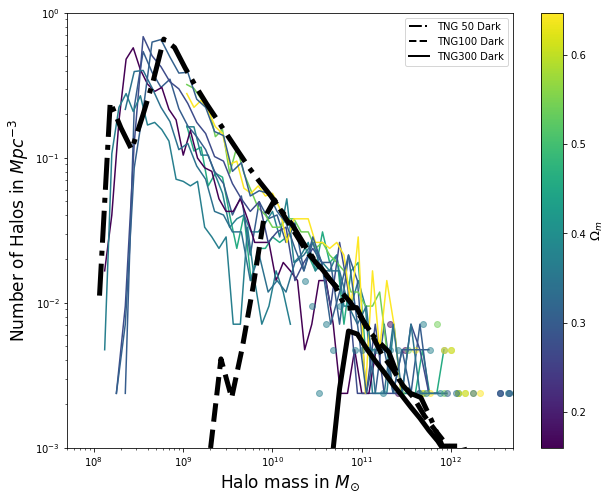

In [36]:
lower_number_cutoff = 1e-5  # cut of lines in plot if number of halos drops below 3 and plot rest as points

fig = plt.figure(figsize=(10,8))

norm = colors.Normalize(vmin=min(Omega0s), vmax=max(Omega0s))
colormap = cm.viridis  # Choose any colormap: viridis, plasma, inferno, etc.
scalar_map = cm.ScalarMappable(norm=norm, cmap=colormap)

for i in range(len(bin_center_lists)):
    color = scalar_map.to_rgba(Omega0s[i])
    
    first_non_zero = np.where(halocount_lists[i]!=0)[0][0]
    if first_non_zero:
        halocount_lists_nice = halocount_lists[i][first_non_zero:]
        bin_center_lists_nice = bin_center_lists[i][first_non_zero:]
    else:
        halocount_lists_nice = halocount_lists[i]
        bin_center_lists_nice = bin_center_lists[i]
        
    l_halocount_list_half = round(len(halocount_lists_nice)/2)
    _temp = np.where(halocount_lists_nice[l_halocount_list_half:]<lower_number_cutoff)[0]
    _temp += l_halocount_list_half
    
    if len(_temp) == 0:
        plt.plot(bin_center_lists_nice, halocount_lists_nice, color=color)
    else:
        
        cutoff_index = _temp[0]

        plt.plot(bin_center_lists_nice[:cutoff_index], halocount_lists_nice[:cutoff_index], color=color)
        plt.plot(bin_center_lists_nice[cutoff_index:], halocount_lists_nice[cutoff_index:], color=color,
                 marker="o", linestyle="None", alpha=0.5)
    
cbar = plt.colorbar(scalar_map)
cbar.set_label(r'$\Omega_m$', fontsize=13)

################# Plot reference lines from TNG 50 Simulation #################

bin_centers_tng_50, y_vals_tng_50 = get_halo_mass_function(subhalos_tng_50, boxsize_tng_50)
bin_centers_tng_50 = bin_centers_tng_50

l_y_vals_tng_50_half = round(len(y_vals_tng_50)/2)
_temp = np.where(y_vals_tng_50[l_y_vals_tng_50_half:]<lower_number_cutoff)[0]
_temp += l_y_vals_tng_50_half

if len(_temp) == 0:
    plt.plot(bin_centers_tng_50, y_vals_tng_50, color="black", linestyle="-.", linewidth=5, label="TNG50 Dark")
else:
    cutoff_index_tng_50 = _temp[0]
    
    plt.plot(bin_centers_tng_50[:cutoff_index_tng_50], y_vals_tng_50[:cutoff_index_tng_50], color="black",
             linestyle="-.", linewidth=5, label="TNG 50 Dark")
    plt.plot(bin_centers_tng_50[cutoff_index_tng_50:], y_vals_tng_50[cutoff_index_tng_50:], color="black",
             marker="o", linestyle="None", alpha=0.5)

################# Plot reference lines from TNG 100 Simulation #################
    
bin_centers_tng_100, y_vals_tng_100 = get_halo_mass_function(subhalos_tng_100, boxsize_tng_100)
bin_centers_tng_100 = bin_centers_tng_100

l_y_vals_tng_100_half = round(len(y_vals_tng_100)/2)
_temp = np.where(y_vals_tng_100[l_y_vals_tng_100_half:]<lower_number_cutoff)[0]
_temp += l_y_vals_tng_100_half

if len(_temp) == 0:
    plt.plot(bin_centers_tng_100, y_vals_tng_100, color="black", linestyle="--", linewidth=5, label="TNG100 Dark")
    
else:
    cutoff_index_tng_100 = _temp[0]
    
    plt.plot(bin_centers_tng_100[:cutoff_index_tng_100], y_vals_tng_100[:cutoff_index_tng_100], color="black",
             linestyle="--", linewidth=5, label="TNG100 Dark")
    plt.plot(bin_centers_tng_100[cutoff_index_tng_100:], y_vals_tng_100[cutoff_index_tng_100:], color="black",
             marker="o", linestyle="None", alpha=0.5)

################# Plot reference lines from TNG 300 Simulation #################
    
bin_centers_tng_300, y_vals_tng_300 = get_halo_mass_function(subhalos_tng_300, boxsize_tng_300)
bin_centers_tng_300 = bin_centers_tng_300

l_y_vals_tng_300_half = round(len(y_vals_tng_300)/2)
_temp = np.where(y_vals_tng_300[l_y_vals_tng_300_half:]<lower_number_cutoff)[0]
_temp += l_y_vals_tng_300_half

if len(_temp) == 0:
    plt.plot(bin_centers_tng_300, y_vals_tng_300, color="black", linestyle="-", linewidth=5, label="TNG300 Dark")
    
else:
    cutoff_index_tng_300 = _temp[0]
    
    plt.plot(bin_centers_tng_300[:cutoff_index_tng_300], y_vals_tng_300[:cutoff_index_tng_300], color="black",
             linestyle="-", linewidth=5, label="TNG300 Dark")
    plt.plot(bin_centers_tng_300[cutoff_index_tng_300:], y_vals_tng_300[cutoff_index_tng_300:], color="black",
             marker="o", linestyle="None", alpha=0.5)

#################                                             #################

plt.yscale("log")
plt.xscale("log")
plt.ylim([1e-3, 1e0])
plt.xlim([5e7, 5e12])
plt.ylabel(r"Number of Halos in $Mpc^{-3}$", fontsize=17)
plt.xlabel(r"Halo mass in $M_{\odot}$", fontsize=17)
plt.legend(handlelength=2, handletextpad=0.5)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(2)
plt.savefig("plots/halo_mass_functions.pdf", format="PDF")
plt.show()